# Packages Import

In [ ]:
import os
import random
import zipfile

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import albumentations as A
import tensorflow as tf
import tensorflow_datasets as tfds


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading Data

The dataset has been zipped and uploaded to google drive to use it in colab. Fixed random rotate has been used to train this model. The zip file is extracted then the data is loaded from the tensorflow format to a pandas dataframe in order to be used with the augmentation pipeline. Before applying the augmentation, the data is split 80% training and validation, 20% testing. We have 720 images and 20% for testing is a decent ratio. Augmentation will also increase our dataset by 6X.

In [ ]:
# Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes = 8
num_images = 720

In [ ]:
# Path to your zip file
zip_file_path = '/content/drive/MyDrive/tensorflow_data_.zip'

# Path where you want to extract the zip file
extract_to_path = '.'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the directory specified
    zip_ref.extractall(extract_to_path)

print("Extraction complete.")

Extraction complete.


In [ ]:
# Load the dataset
data_path = os.path.join(os.getcwd(), "tensorflow_data")
flow_data_set = tfds.load('elg7186_projectdata/fixed_random_rotate',
                          data_dir=data_path,
                          split='train')

# Prepare a list to hold the data
data = []

# Iterate over the dataset
for item in tfds.as_numpy(flow_data_set):
    video_frames = item['video']
    segmentation_masks = item['segmentations']

    # Iterate over each frame and its corresponding mask
    for idx, (frame, mask) in enumerate(zip(video_frames, segmentation_masks)):
        # Flatten the frame and mask for DataFrame storage, or use another method as needed
        frame_shaped = frame.reshape(256, 256, 3)
        mask_shaped = mask.reshape(256, 256)

        # frame_shaped = frame.flatten()
        # mask_shaped = mask.flatten()
        # Append the data as a dict to the data list
        data.append({
            # 'frame_index': idx,
            'frame': frame_shaped,  # Storing flattened frames directly could be very memory-intensive
            'mask': mask_shaped     # Consider storing file paths or another identifier instead
        })

# Create the DataFrame
data = pd.DataFrame(data)

In [ ]:
train_data, test_data = train_test_split(data,
                                        test_size = 0.2,
                                        random_state=42)

In [ ]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Augmentation

Augmentation is important step in these tasks in order to create a more robust model. Since this is a multi-class segmentation various techniques likes rotation, flipping, dropout and other image manipulation techniques are applied.<br>
After applying the augmentations techniques, the images are normalized in order to feed them to our U-Net model

In [ ]:
# Define the augmentation pipeline
augmentation = A.Compose([
    # Geometric transformations
    A.Rotate(limit=35, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),

    # Photometric transformations
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.2),
    A.GaussNoise(p=0.3),

    # Advanced techniques
    A.CoarseDropout(max_holes=3, max_height=8, max_width=8, min_holes=None,
                    min_height=None, min_width=None, fill_value=0, p=0.3),
])

# Applying the augmentations
def apply_augmentations(row):
    augmented = augmentation(image=row['frame'], mask=row['mask'])
    row['frame'], row['mask'] = augmented['image'], augmented['mask']
    return row

In [ ]:
df_augmented = pd.DataFrame()
for _ in range(5):
    df_tmp = pd.DataFrame()
    df_tmp = train_data.copy().apply(apply_augmentations, axis=1)
    df_augmented = pd.concat([df_augmented, df_tmp], axis=0).copy()

del df_tmp

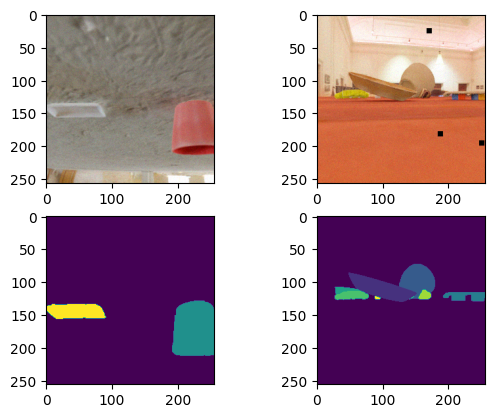

In [ ]:
img_idx = 1
fig, axs = plt.subplots(2, 2)

axs[0][0].imshow(df_augmented["frame"].iloc[img_idx].squeeze())
axs[0][1].imshow(df_augmented["frame"].iloc[img_idx + 24].squeeze())

axs[1][0].imshow(df_augmented["mask"].iloc[img_idx])
axs[1][1].imshow(df_augmented["mask"].iloc[img_idx + 24])
plt.show()

In [ ]:
train_data = pd.concat([train_data, df_augmented], axis=0)
del df_augmented

In [ ]:
train_data = train_data.reset_index(drop=True)

In [ ]:
images = train_data["frame"]
masks = train_data["mask"]

images = np.array(images.to_list())
images = np.expand_dims(images, axis = 4)
masks = np.array(masks.to_list())
masks = np.expand_dims(masks, axis = 3)

# Normalize images
images = images / 255.0

# Saving Data to Disk

After preprocessing the train data, it's saved to the disk in order to used in the next stage for the model training. The test dataset is also saved to the disk.

In [ ]:
print("Image data shape is: ", images.shape)
print("Mask data shape is: ", masks.shape)
print("Max pixel value in image is: ", images.max())
print("Labels in the mask are : ", np.unique(masks))

Image data shape is:  (3456, 256, 256, 3, 1)
Mask data shape is:  (3456, 256, 256, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0 1 2 3 4 5 6 7]


In [ ]:
# Convert the NumPy arrays into a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((images, masks))

# Save the dataset
tf.data.Dataset.save(dataset, '/content/drive/MyDrive/cv_data/train')

In [ ]:
test_images = test_data["frame"]
test_masks = test_data["mask"]

test_images = np.array(test_images.to_list())
test_images = np.expand_dims(test_images, axis = 4)
test_masks = np.array(test_masks.to_list())
test_masks = np.expand_dims(test_masks, axis = 3)

test_images = test_images / 255.0

In [ ]:
print("Image data shape is: ", test_images.shape)
print("Mask data shape is: ", test_masks.shape)
print("Max pixel value in image is: ", test_images.max())
print("Labels in the mask are : ", np.unique(test_masks))

Image data shape is:  (144, 256, 256, 3, 1)
Mask data shape is:  (144, 256, 256, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0 1 2 3 4 5 6 7]


In [ ]:
# Convert the NumPy arrays into a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

# Save the dataset
tf.data.Dataset.save(dataset, '/content/drive/MyDrive/cv_data/test')
